p_AB per step = 0.020000, p_BC per step = 0.025000
Initial total (mean) = 5000.0, final total (mean) = 5000.0


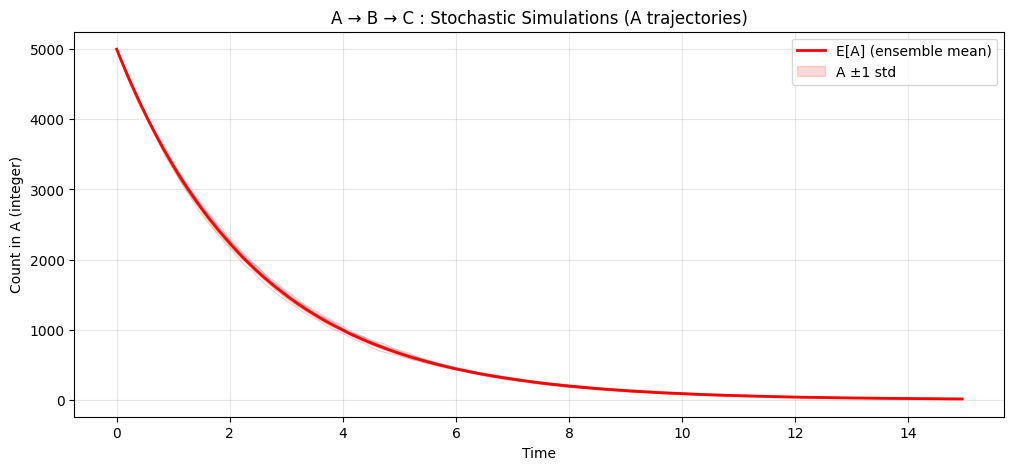

A few time points:
t= 0.00 | mean A=  5000.0  mean B=     0.0  mean C=     0.0
t= 2.95 | mean A=  1519.1  mean B=  1581.9  mean C=  1899.0
t= 5.95 | mean A=   449.9  mean B=   827.0  mean C=  3723.1
t= 8.95 | mean A=   133.0  mean B=   323.7  mean C=  4543.3
t=11.95 | mean A=    39.2  mean B=   112.3  mean C=  4848.5
t=14.95 | mean A=    11.6  mean B=    37.2  mean C=  4951.2


In [1]:
# %% [markdown]
# # A -> B -> C : Stochastic Simulation (Integer Counts, Matrix Updates)
# We simulate M independent runs. At each step j:
#   - Each A decays to B with prob p_AB = alpha * dt
#   - Each B decays to C with prob p_BC = kappa * dt
# We update integer matrices A, B, C of shape (M, Tdt).

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Parameters (edit as needed)
# -----------------------------
M    = 100        # ensemble size (number of independent simulations)
Tdt  = 300        # number of time steps
dt   = 0.05       # time step
t    = np.arange(0, Tdt*dt, dt)  # time grid

alpha = 0.4       # rate A->B
kappa = 0.5       # rate B->C

# Initial integer counts per simulation
N_A0, N_B0, N_C0 = 5000, 0, 0

# -----------------------------
# Arrays (INTEGER)
# -----------------------------
A = np.zeros((M, Tdt), dtype=np.int32)
B = np.zeros((M, Tdt), dtype=np.int32)
C = np.zeros((M, Tdt), dtype=np.int32)

A[:, 0] = N_A0
B[:, 0] = N_B0
C[:, 0] = N_C0

# -----------------------------
# Precompute per-step probabilities (constants here)
# -----------------------------
p_AB = alpha * dt
p_BC = kappa * dt

# Safety (keep probabilities in [0,1])
p_AB = float(min(1.0, max(0.0, p_AB)))
p_BC = float(min(1.0, max(0.0, p_BC)))

print(f"p_AB per step = {p_AB:.6f}, p_BC per step = {p_BC:.6f}")

# RNG
rng = np.random.default_rng(seed=123)

# -----------------------------
# Simulation loop (vectorized across simulations)
# -----------------------------
for j in range(1, Tdt):
    # How many from A go to B in each simulation
    AB = rng.binomial(A[:, j-1], p_AB)            # integers, shape (M,)
    # How many from B go to C
    BC = rng.binomial(B[:, j-1], p_BC)

    # Update integer matrices
    A[:, j] = A[:, j-1] - AB
    B[:, j] = B[:, j-1] + AB - BC
    C[:, j] = C[:, j-1] + BC

# -----------------------------
# Ensemble stats
# -----------------------------
mean_A = A.mean(axis=0)
std_A  = A.std(axis=0)

mean_B = B.mean(axis=0)
std_B  = B.std(axis=0)

mean_C = C.mean(axis=0)
std_C  = C.std(axis=0)

# Sanity: total should be conserved (up to integer arithmetic — exactly here)
total_mean = mean_A + mean_B + mean_C
print(f"Initial total (mean) = {total_mean[0]:.1f}, final total (mean) = {total_mean[-1]:.1f}")

# -----------------------------
# Visualization
# -----------------------------
plt.figure(figsize=(12,5))
# Plot a few sample trajectories for A (like your undecayed-N plot)
for i in range(min(10, M)):
    plt.plot(t, A[i], alpha=0.25, lw=0.8)

# Ensemble bands for A
plt.plot(t, mean_A, 'r-', lw=2, label='E[A] (ensemble mean)')
plt.fill_between(t, mean_A-std_A, mean_A+std_A, color='red', alpha=0.15, label='A ±1 std')

plt.xlabel('Time')
plt.ylabel('Count in A (integer)')
plt.title('A → B → C : Stochastic Simulations (A trajectories)')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Quick table print
print(f"A few time points:")
for idx in np.linspace(0, Tdt-1, 6, dtype=int):
    print(f"t={t[idx]:5.2f} | mean A={mean_A[idx]:8.1f}  mean B={mean_B[idx]:8.1f}  mean C={mean_C[idx]:8.1f}")

p_AB per step = 0.020000, p_BC per step = 0.025000
Initial total (mean) = 5000.0, final total (mean) = 5000.0


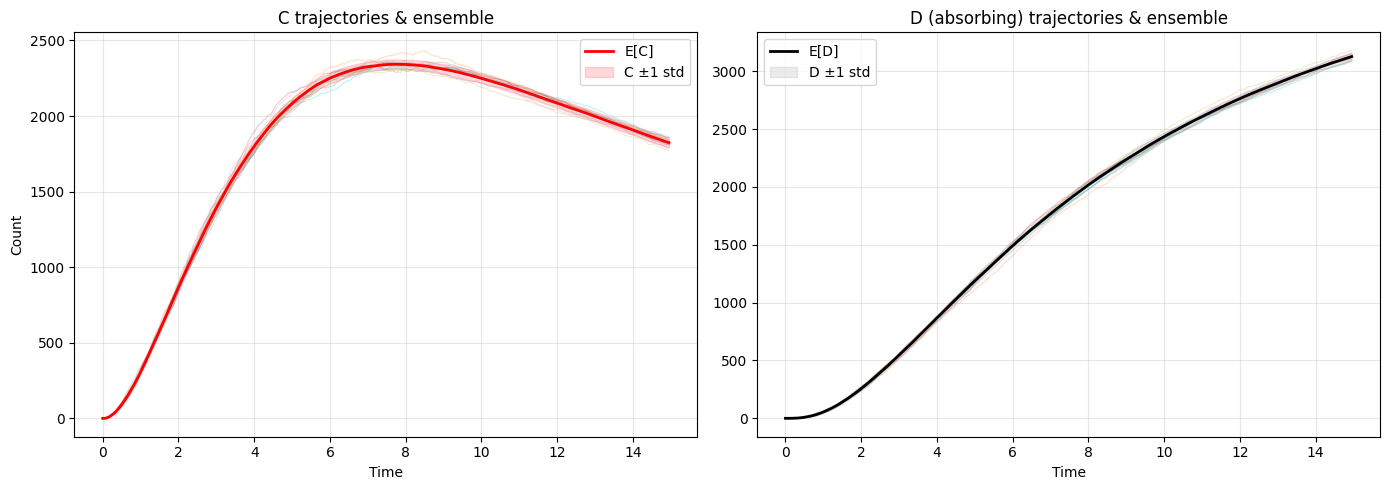

A few time points (means):
t= 0.00 | A=  5000.0  B=     0.0  C=     0.0  D=     0.0
t= 2.95 | A=  1519.9  B=  1580.0  C=  1369.6  D=   530.4
t= 5.95 | A=   453.8  B=   825.7  C=  2243.9  D=  1476.6
t= 8.95 | A=   135.3  B=   325.8  C=  2312.0  D=  2227.0
t=11.95 | A=    40.0  B=   114.4  C=  2090.1  D=  2755.5
t=14.95 | A=    12.1  B=    37.7  C=  1823.6  D=  3126.7


In [2]:
# %% [markdown]
# # A -> B -> C -> D (time-dependent C->D): Stochastic Simulation
# Integer-count, vectorized Binomial updates:
#   p_AB = alpha*dt
#   p_BC = kappa*dt
#   p_CD(j) = g(t_j)*dt = [eta/(1+t_j)]*dt   (depends only on time, same for all sims at step j)

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Parameters
# -----------------------------
M    = 100
Tdt  = 300
dt   = 0.05
t    = np.arange(0, Tdt*dt, dt)

alpha = 0.4   # A->B
kappa = 0.5   # B->C
eta   = 0.9   # C->D uses g(t) = eta/(1+t)

N_A0, N_B0, N_C0, N_D0 = 5000, 0, 0, 0

# -----------------------------
# Arrays (INTEGER)
# -----------------------------
A = np.zeros((M, Tdt), dtype=np.int32)
B = np.zeros((M, Tdt), dtype=np.int32)
C = np.zeros((M, Tdt), dtype=np.int32)
D = np.zeros((M, Tdt), dtype=np.int32)

A[:, 0] = N_A0
B[:, 0] = N_B0
C[:, 0] = N_C0
D[:, 0] = N_D0

# -----------------------------
# Probabilities per step
# -----------------------------
p_AB = float(min(1.0, max(0.0, alpha * dt)))
p_BC = float(min(1.0, max(0.0, kappa * dt)))
# p_CD is time-dependent: p_CD[j] = min(1, eta/(1+t[j-1]) * dt)
# Using left-endpoint t_{j-1} like Forward Euler-style updates.
print(f"p_AB per step = {p_AB:.6f}, p_BC per step = {p_BC:.6f}")

# RNG
rng = np.random.default_rng(seed=456)

# -----------------------------
# Simulation loop
# -----------------------------
for j in range(1, Tdt):
    # time-dependent probability for this step (common to all sims)
    g_t  = eta / (1.0 + t[j-1])
    p_CD = float(min(1.0, max(0.0, g_t * dt)))

    # Draw transitions (vectorized Binomial)
    AB = rng.binomial(A[:, j-1], p_AB)      # A -> B
    BC = rng.binomial(B[:, j-1], p_BC)      # B -> C
    CD = rng.binomial(C[:, j-1], p_CD)      # C -> D (time-dependent)

    # Update integer matrices
    A[:, j] = A[:, j-1] - AB
    B[:, j] = B[:, j-1] + AB - BC
    C[:, j] = C[:, j-1] + BC - CD
    D[:, j] = D[:, j-1] + CD

# -----------------------------
# Ensemble stats
# -----------------------------
mean_A = A.mean(axis=0); std_A = A.std(axis=0)
mean_B = B.mean(axis=0); std_B = B.std(axis=0)
mean_C = C.mean(axis=0); std_C = C.std(axis=0)
mean_D = D.mean(axis=0); std_D = D.std(axis=0)

# Conservation check
total_mean = mean_A + mean_B + mean_C + mean_D
print(f"Initial total (mean) = {total_mean[0]:.1f}, final total (mean) = {total_mean[-1]:.1f}")

# -----------------------------
# Visualization: show C and D (intermediate + absorbing)
# -----------------------------
fig, ax = plt.subplots(1, 2, figsize=(14,5), sharex=True)

# C trajectories (a few)
for i in range(min(10, M)):
    ax[0].plot(t, C[i], alpha=0.25, lw=0.8)
ax[0].plot(t, mean_C, 'r-', lw=2, label='E[C]')
ax[0].fill_between(t, mean_C-std_C, mean_C+std_C, color='red', alpha=0.15, label='C ±1 std')
ax[0].set_title('C trajectories & ensemble')
ax[0].set_xlabel('Time'); ax[0].set_ylabel('Count'); ax[0].grid(alpha=0.3); ax[0].legend()

# D trajectories (absorbing)
for i in range(min(10, M)):
    ax[1].plot(t, D[i], alpha=0.25, lw=0.8)
ax[1].plot(t, mean_D, 'k-', lw=2, label='E[D]')
ax[1].fill_between(t, mean_D-std_D, mean_D+std_D, color='gray', alpha=0.15, label='D ±1 std')
ax[1].set_title('D (absorbing) trajectories & ensemble')
ax[1].set_xlabel('Time'); ax[1].grid(alpha=0.3); ax[1].legend()

plt.tight_layout()
plt.show()

# Quick table print
print(f"A few time points (means):")
for idx in np.linspace(0, Tdt-1, 6, dtype=int):
    print(f"t={t[idx]:5.2f} | A={mean_A[idx]:8.1f}  B={mean_B[idx]:8.1f}  C={mean_C[idx]:8.1f}  D={mean_D[idx]:8.1f}")
